# 時系列分析(季節&トレンド)

## 方針

- レベル・トレンド・周期性の3要因に分けて、モデルを構築し、予測し、評価する。
- データを訓練データ、バリデーションデータ、テストデータの3つに分け、訓練データによって得られたモデルをバリデーションデータによって評価し、最適なモデルを選択する。テストデータは候補モデルの調査を一通り終えた後、最終評価にのみ使用する。
    - 分割の期間は各パーツ毎に適宜指定する。例えばかなり過去に販売されていたパーツなどは、直近のワランティ件数はほぼ0件であり、「2018年以降」などの一律な期間指定は評価に適さないため。
        - (余談)この方法は評価結果がデータの分割期間に依存する。より期間への依存が少ない方法としては、期間をスライドさせながら複数の評価を行い、その平均値や分布から評価する方法もある。しかしこの方法は、学習に計算時間がかかるモデルについては、計算時間の観点で現実的ではない。**粒子フィルタ(Particle Filter, SMC; Sequential Monte Carloとも)**などの比較的計算時間の少ないパラメータ推定方法では、このような評価方法も可能である。
    - 評価指標としては、バリデーションデータの平均二乗誤差(MSE; Mean Squared Error)を用いる。他、補助的に訓練データのBIC(ベイズ情報量基準)を用いることがある。
- スキルトランスファーの目的のため、以下の手法を用いてそれぞれモデリングを行う。
    - 2. 状態空間モデル(線形-ガウス)
    - 3. 状態空間モデル(非線形-非ガウス)

## データ準備

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

PATH_DATA_INTERIM = Path("../data/interim/")

In [2]:
df_warranty_model_part_num_daily = pd.read_feather(PATH_DATA_INTERIM/"df_warranty_model_part_num_daily.feather")

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [3]:
selected_part_TD = ["27610-76G", "37950-58J", "95411-82K", 
                    "09283-350", "33920-77F", "33220-76G", "55311-75F",
                    "55311-72J", "53200-58J", "84702-70K"]

selected_part_S = ["46860-76G", "95200-58J", "37990-72J", "09262-350",
                   "17400-588"]

In [4]:
ts_dict = {}
ts_dict_monthly = {}
for part in selected_part_TD:
    ts_tmp = (df_warranty_model_part_num_daily
              .loc[df_warranty_model_part_num_daily.part_cd == part,
                          ["date", "n"]]
              .groupby("date")["n"]
              .sum())
    ts_tmp.index = pd.to_datetime(ts_tmp.index)
    ts_dict[part] = ts_tmp
    ts_dict_monthly[part] = ts_tmp.resample("MS").sum()

In [5]:
ts_dict_S = {}
ts_dict_monthly_S = {}
for part in selected_part_S:
    ts_tmp = (df_warranty_model_part_num_daily
              .loc[df_warranty_model_part_num_daily.part_cd == part,
                          ["date", "n"]]
              .groupby("date")["n"]
              .sum())
    ts_tmp.index = pd.to_datetime(ts_tmp.index)
    ts_dict_S[part] = ts_tmp
    ts_dict_monthly_S[part] = ts_tmp.resample("MS").sum()

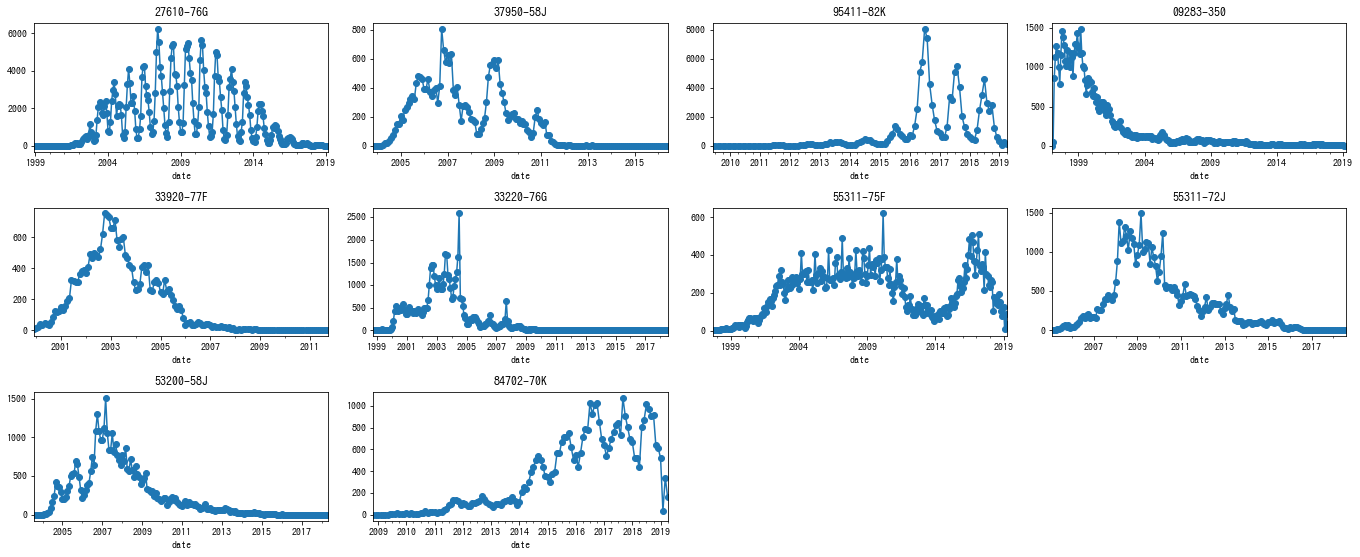

In [6]:
fig = plt.figure(figsize=(19,10))
for i, (part, ts) in enumerate(ts_dict_monthly.items()):
    ax = fig.add_subplot(4,4,i+1)
    ts.plot(style="-o", title=part, ax=ax)

plt.tight_layout()

In [7]:
df_term_devide = pd.DataFrame([{"part":"27610-76G", "valid_start":"2013-01-01", "test_start":"2014-01-01"},
                               {"part":"37950-58J", "valid_start":"2009-01-01", "test_start":"2010-01-01"},
                               {"part":"95411-82K", "valid_start":"2016-01-01", "test_start":"2017-01-01"},
                               {"part":"09283-350", "valid_start":"2000-01-01", "test_start":"2001-01-01"},
                               {"part":"33920-77F", "valid_start":"2003-01-01", "test_start":"2004-01-01"},
                               {"part":"33220-76G", "valid_start":"2003-01-01", "test_start":"2004-01-01"},
                               {"part":"55311-75F", "valid_start":"2016-01-01", "test_start":"2017-01-01"},
                               {"part":"55311-72J", "valid_start":"2011-01-01", "test_start":"2012-01-01"},
                               {"part":"53200-58J", "valid_start":"2008-01-01", "test_start":"2009-01-01"},
                               {"part":"84702-70K", "valid_start":"2016-01-01", "test_start":"2017-01-01"}])
df_term_devide.set_index("part", inplace=True)
df_term_devide["valid_start"] = pd.to_datetime(df_term_devide.valid_start)
df_term_devide["test_start"] = pd.to_datetime(df_term_devide.test_start)

In [9]:
from datetime import datetime, timedelta

ts_dict_monthly_train, ts_dict_monthly_valid, ts_dict_monthly_test = {},{},{}

for part in selected_part_TD:
    valid_start = df_term_devide.loc[part, "valid_start"]
    test_start = df_term_devide.loc[part, "test_start"]
    train_end = valid_start - timedelta(1)
    valid_end = test_start - timedelta(1)
    
    ts_dict_monthly_train[part] = ts_dict_monthly[part].loc[:train_end]
    ts_dict_monthly_valid[part] = ts_dict_monthly[part].loc[valid_start:valid_end]
    ts_dict_monthly_test[part] = ts_dict_monthly[part].loc[test_start:]

In [10]:
# スズキチームのパーツ(ts_dict_monthly_S)について時系列をプロットしてみましょう


In [11]:
# 各パーツについて、バリデーション期間開始日、テスト期間開始日を指定しましょう


In [12]:
# 各データを訓練、バリデーション、テストに分けましょう


## 状態空間モデル(線形-ガウス)

- ライブラリはstatsmodelsを使用する。
- 以下のような状態空間モデルを仮定し、パラメータと状態$s_{t}$を推定する。
$$y_{t} \sim N(\mu_{t} + c_{t}) \\
\mu_{t} \sim N(\mu_{t-1} + d_{t-1}, \sigma_{v}) \\ 
d_{t} \sim N(d_{t-1}, \sigma_{d}) \\
c_{t} \sim N(-\sum_{k=t-11}^{k=t-1}c_{k}, \sigma_{c}) \\
$$

ここで、$y_{t}$は観測値、$\mu_{t}$はレベル, $d_{t}$はトレンド, $c_{t}$は周期成分である。  

In [19]:
ts_monthly = ts_dict_monthly["27610-76G"]
ts_monthly_train = ts_dict_monthly_train["27610-76G"]
ts_monthly_valid = ts_dict_monthly_valid["27610-76G"]

In [16]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

m_dlm = UnobservedComponents(ts_monthly_train, 'local linear trend', 
                             freq_seasonal=[{"period":12}]).fit()

In [17]:
m_dlm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                
=============================================================================================
Dep. Variable:                                     n   No. Observations:                  169
Model:                            local linear trend   Log Likelihood               -1157.095
                   + stochastic freq_seasonal(12(6))   AIC                           2322.190
Date:                               Wed, 31 Jul 2019   BIC                           2334.363
Time:                                       12:11:28   HQIC                          2327.134
Sample:                                   12-01-1998                                         
                                        - 12-01-2012                                         
Covariance Type:                                 opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sigma2.irregular               0.0005   1.14e+04   3.95e-08      1.000   -2.24e+04    2.24e+04
sigma2.level                1.188e+04   4803.876      2.473      0.013    2462.942    2.13e+04
sigma2.trend                  27.3543     36.392      0.752      0.452     -43.972      98.681
sigma2.freq_seasonal_12(6)  1514.4694    271.339      5.581      0.000     982.654    2046.285
===================================================================================
Ljung-Box (Q):                      248.58   Jarque-Bera (JB):                 9.42
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               1.31   Skew:                             0.15
Prob(H) (two-sided):                  0.34   Kurtosis:                         4.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

BIC:2334.36


/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


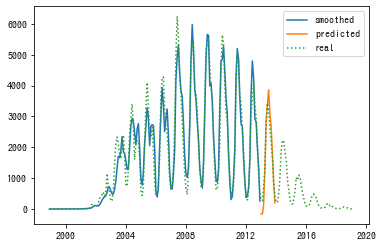

In [20]:
print(f"BIC:{m_dlm.bic:.2f}")
pred = m_dlm.predict()
ax = plt.subplot(1,1,1)
ax.plot(pred.index, pred.values, label="smoothed")
forc = m_dlm.forecast(12)
ax.plot(forc.index, forc.values, label="predicted")
ax.plot(ts_monthly.index, ts_monthly.values, ":", label="real")
ax.legend()

RMSE: 383.90


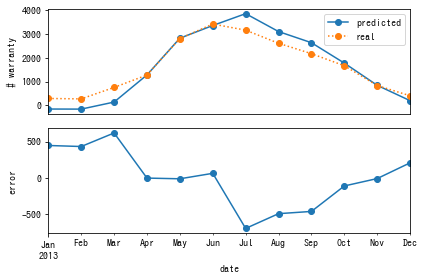

In [21]:
pred = m_dlm.forecast(12)
ax = plt.subplot(2,1,1)
pred.plot(ax=ax, style="o-", label="predicted")
ts_monthly_valid.plot(ax=ax, style="o:", label="real")
ax.set_ylabel("# warranty")
ax.legend()

ax.get_xaxis().set_visible(False)
ax = plt.subplot(2,1,2)
err = ts_monthly_valid - pred
err.plot(ax=ax, style="o-", label="err")
ax.set_ylabel("error")
plt.tight_layout()
print(f"RMSE: {np.sqrt((err**2).mean()):.2f}")

In [22]:
m_dlm_l1p = UnobservedComponents(np.log1p(ts_monthly_train), 'local linear trend', 
                                 freq_seasonal=[{"period":12}]).fit()
m_dlm_l1p.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                
=============================================================================================
Dep. Variable:                                     n   No. Observations:                  169
Model:                            local linear trend   Log Likelihood                 -61.856
                   + stochastic freq_seasonal(12(6))   AIC                            131.713
Date:                               Wed, 31 Jul 2019   BIC                            143.887
Time:                                       12:12:42   HQIC                           136.658
Sample:                                   12-01-1998                                         
                                        - 12-01-2012                                         
Covariance Type:                                 opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sigma2.irregular               0.0246      0.007      3.561      0.000       0.011       0.038
sigma2.level                   0.0009      0.006      0.148      0.882      -0.011       0.012
sigma2.trend                   0.0006      0.000      2.192      0.028    6.27e-05       0.001
sigma2.freq_seasonal_12(6)     0.0005      0.000      2.998      0.003       0.000       0.001
===================================================================================
Ljung-Box (Q):                       65.49   Jarque-Bera (JB):                51.22
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.09   Skew:                             0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

BIC:143.89


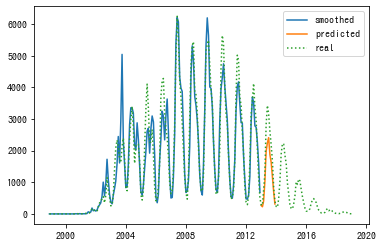

In [23]:
print(f"BIC:{m_dlm_l1p.bic:.2f}")
pred = np.expm1(m_dlm_l1p.predict())
ax = plt.subplot(1,1,1)
ax.plot(pred.index, pred.values, label="smoothed")
forc = np.expm1(m_dlm_l1p.forecast(12))
ax.plot(forc.index, forc.values, label="predicted")
ax.plot(ts_monthly.index, ts_monthly.values, ":", label="real")
ax.legend()

MSE: 577.75


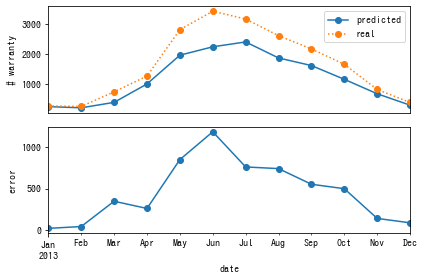

In [24]:
pred = np.expm1(m_dlm_l1p.forecast(12))
ax = plt.subplot(2,1,1)
pred.plot(ax=ax, style="o-", label="predicted")
ts_monthly_valid.plot(ax=ax, style="o:", label="real")
ax.set_ylabel("# warranty")
ax.legend()

ax.get_xaxis().set_visible(False)
ax = plt.subplot(2,1,2)
err = ts_monthly_valid - pred
err.plot(ax=ax, style="o-", label="err")
ax.set_ylabel("error")
plt.tight_layout()
print(f"MSE: {np.sqrt((err**2).mean()):.2f}")

## StateSpaceModel(NonLinear-NonGaussian)

- Use PyStan library (Stan backend)
- We assume following state spece model and estimate each parameters
$$y_{t} \sim Poisson(exp(\mu_{t} + c_{t})) \\
\mu_{t} \sim N(\mu_{t-1} + d_{t-1}, \sigma_{v}) \\ 
d_{t} \sim N(d_{t-1}, \sigma_{d}) \\
c_{t} \sim N(-\sum_{k=t-11}^{k=t-1}c_{k}, \sigma_{c}) \\
$$

$\mu_{t}$ is local level + drift(trend), $d_{t}$ is drift(trend), $c_{t}$ is cycle.  
As we assume average of $y_{t}$ is $exp(\mu_{t} + c_{t})$, we assume following relationship. 
$$Average(y_{t}) = exp(\mu_{t-1}) \cdot exp(d_{t-1}) \cdot exp(c_{t}) \cdot exp(\epsilon_{t})$$
$$\epsilon_{t} \sim N(0, \sigma_{v})$$

For estimating this type of model (Non-Linear, Non-Gaussian), we have 2 method,
- Particle Filter
- MCMC

this time, we use MCMC, with library "Stan".

In [25]:
import pystan

In [64]:
model = """data {
  int<lower=1> n;
  int<lower=1> m;
  int y[n];  
}
parameters {
  vector[n] mu;
  vector[n] trend;
  vector[n] seasonal;
  real<lower=0> sigma_level;
  real<lower=0> sigma_trend;
  real<lower=0> sigma_seas;
  real<lower=0> sigma_irreg;
}
transformed parameters {
  vector[n] yhat;
  yhat = exp(mu + seasonal);
}
model {
  for(t in 12:n)
    seasonal[t] ~ normal(- sum(seasonal[t-11:t-1]), sigma_seas);

  for(t in 2:n)
  {
    mu[t] ~ normal(mu[t-1] + trend[t-1], sigma_level);
    trend[t] ~ normal(trend[t-1], sigma_trend);
  }
  
  y ~ poisson(yhat);
}
generated quantities {
    vector[n + m] seasonal_pred;
    vector[n + m] mu_pred;
    vector[n + m] trend_pred;
    seasonal_pred[1:n] = seasonal;
    mu_pred[1:n] = mu;
    trend_pred[1:n] = trend;

    for (t in 1:m) {
        seasonal_pred[n+t] = normal_rng(- sum(seasonal_pred[(n+t-11):(n+t-1)]), sigma_seas);
        mu_pred[n+t] = normal_rng(mu_pred[n+t-1] + trend_pred[n+t-1], sigma_level);
        trend_pred[n+t] = normal_rng(trend_pred[n+t-1], sigma_trend);
    }
}
"""

In [65]:
dat = {"y": ts_monthly_train.values,
      "n": len(ts_monthly_train),
      "m":12}

sm = pystan.StanModel(model_code=model)
fit = sm.sampling(data=dat, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d67fe3a5980a0817913785724e18d168 NOW.


In [66]:
len(ts_monthly_train)

169

In [67]:
len(cycle_pred)

181

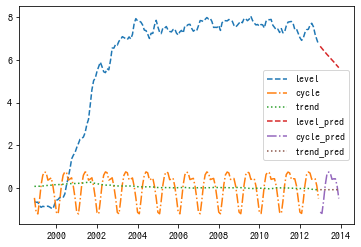

In [70]:
la = fit.extract(permuted=True, inc_warmup=False)  # return a dictionary of arrays

level = la["mu"].mean(axis=0)
cycle = la["seasonal"].mean(axis=0)
trend = la["trend"].mean(axis=0)
yhat = la["yhat"].mean(axis=0)
level_pred = la["mu_pred"].mean(axis=0)
cycle_pred = la["seasonal_pred"].mean(axis=0)
trend_pred= la["trend_pred"].mean(axis=0)

plt.plot(ts_monthly_train.index, level, "--",label="level")
plt.plot(ts_monthly_train.index, cycle, "-.", label="cycle")
plt.plot(ts_monthly_train.index, trend, ":", label="trend")
plt.plot(ts_monthly_valid.index, level_pred[169:], "--",label="level_pred")
plt.plot(ts_monthly_valid.index, cycle_pred[169:], "-.", label="cycle_pred")
plt.plot(ts_monthly_valid.index, trend_pred[169:], ":", label="trend_pred")

plt.legend()

In [74]:
from scipy.stats import poisson

y_pred = poisson.rvs(mu=np.exp(level_pred[169:] + cycle_pred[169:]))

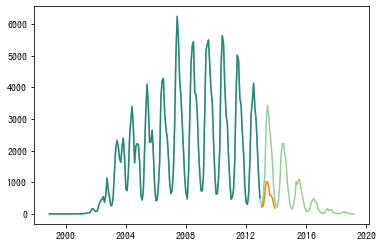

In [76]:
plt.plot(ts_monthly_train.index, yhat, "-", label="trained")
plt.plot(ts_monthly_valid.index, y_pred, "-", label="predicted")
plt.plot(ts_monthly, "-", alpha=0.5, label="real")


- y is underestimated
- Negative trend is outerpolated inappropriately.
- We can separate state as car number $N_{t}$ and probability of warranty $p_{t}$, and estimate $N_{t}$ from production data.